In [1]:
import os
import re
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [3]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))

In [4]:
wikid = pd.read_parquet(os.path.join("data","wikidata.parquet"))

In [5]:
wikid.columns

Index(['024_a', 'ceny', 'druh_umrti', 'facebook', 'instagram',
       'jazykove_verze', 'label_cs', 'label_en', 'manzelstvo', 'obcanstvi',
       'partnerstvo', 'popis_cs', 'popis_en', 'potomstvo', 'pricina_umrti',
       'profese', 'role', 'skoly', 'sourozenectvo', 'strany', 'twitter',
       'udalosti', 'vezeni', 'w_gender', 'w_misto_narozeni', 'w_misto_umrti',
       'w_narozeni', 'w_narozeni_presne', 'w_umrti', 'w_umrti_presne', 'web',
       'wiki_cs', 'wiki_en'],
      dtype='object')

In [6]:
wikid = wikid.reset_index(drop=False).rename(columns={"index": "100_7"})

In [7]:
df = df.merge(pd.read_parquet(os.path.join('data','cnb_vyber.parquet')), left_index=True, right_index=True, how="left")

In [8]:
df = df.explode('100_7')

In [9]:
df = df.merge(wikid, left_on='100_7', right_on='100_7', how='left')

In [10]:
df = df[(df['w_umrti'] >= df['rok']) | (df['w_umrti'].isnull())]

In [11]:
df

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,024_a,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en
0,1804.0,Mrawné propowjdky s prawdiwýma přjklady vtwrzené,Hanke z Hankenštejna Jan Alois,jk01033422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1804.0,Wesnického Faráře Rozmlauwánj s swými Osadniky,Rulík Jan,jk01103049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1807.0,Zrcadlo wýborného sedlského obcowánj předstawu...,Němeček František,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1807.0,Ladislaw a djtky geho,Nejedlý Vojtěch,jk01082969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1808.0,"Cytara nowého zákona prawého Boha, w předrahýc...",Koniáš Antonín,jk01061522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47631,2024.0,Osiřelo dítě,Kučera Štěpán,js20030216066,240917s2024 xr g 000 j cze,[978-80-242-9989-1],None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, 82-322.4, (437.3), (0:82-322.4)...",[aut],js20030216066,"Kučera, Štěpán,",1985-,None,Osiřelo dítě :,"Štěpán Kučera, Michal Sýkora, Martin Goffa, Lu...",None,None,None,[Vydání první],None,None,None,None,None,None,None,[Praha :],"[Euromedia Group,]",[2024],[1],[342 stran ;],None,[21 cm],None,None,[Na obálce uvedeno nakladatelství: Kalibr],None,None,[21. století],"[česká povídka, thriller (povídka), Czech

In [12]:
df[df['100_a'].astype(str).str.contains('Poláček, Karel')]

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,024_a,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en
5724,1926.0,Povídky israelského vyznání,Poláček Karel,jk01100136,000217s1926 xr ||| | cze,None,None,None,None,None,None,None,[821.162.3-3],[Česká próza],[821.162.3-32],[aut],jk01100136,"Poláček, Karel,",1892-1945,None,Povídky israelského vyznání /,Karel Poláček,None,None,None,None,None,[Praha :],"[Pokrok,]",[1926],None,None,None,None,None,None,None,[76 s. ;],None,[8°],[Dobrá četba ;],[sv. 11],None,None,None,None,None,None,None,None,None,None,[české povídky],None,None,None,None,None,None,None,None,[Dobrá četba (Pokrok)],None,None,nam a22 1 4500,Q571203,[Řád Tomáše Garrigua Masaryka II. třídy],None,None,None,"[fr, de, fa, sk, arz, uk, it, eo, cs, en, ru]",Karel Poláček,Karel Poláček,[Ada Poláčková],"[Předlitavsko, Československo]",[Dora Vaňáková],"český humorista, novinář, romanopisec, scenári...","Czech humorist, publicist, bookwriter, scriptw...",None,None,"[spisovatel, scenárista, novinář, filmový scen...",[oběť holokaustu],[Právnická fakulta Univerzity Karlovy],"[Arnošt Poláček, Zdeněk Poláček]",None,None,"[oběť holokaustu, Transport De, Transport Es]","[Koncentrační tábor Osvětim, Židovské ghetto T...",muž,[Rychnov nad Kněžnou],"[Gliwice, Osvětim, Koncentrační tábor Osvětim]",1892.0,+1892-03-22T00:00:00Z,1945.0,+1945-01-21T00:00:00Z,None,https://cs.wikipedia.org/wiki/Karel_Pol%C3%A1%...,https://en.wikipedia.org/wiki/Karel_Pol%C3%A1%...
6853,1931.0,Hráči,Poláček Karel,jk01100136,991123s1931 xr a 000 1 cze,None,None,[(Brož.)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-3, (0:82-321.5)]",[aut],jk01100136,"Poláček, Karel,",1892-1945,None,Hráči :,Karel Poláček ; [ilustrace ... O. Mrkvičky],None,None,None,None,None,[Praha :],"[Fr. Borový,]",[1931],[(v Brně :],[Polygrafia)],None,None,None,None,None,[223 s. :],[il. ;],[21 cm],[Knihy Karla Poláčka ;],[2],None,None,None,None,None,None,None,None,None,None,"[české prózy, humoristické prózy, Czech prose,...",None,None,None,None,None,None,None,None,None,None,None,nam a22 1 4500,Q571203,[Řád Tomáše Garrigua Masaryka II. třídy],None,None,None,"[fr, de, fa, sk, arz, uk, it, eo, cs, en, ru]",Karel Poláček,Karel Poláček,[Ada Poláčková],"[Předlitavsko, Československo]",[Dora Vaňáková],"český humorista, novinář, romanopisec, scenári...","Czech humorist, publicist, bookwriter, scriptw...",None,None,"[spisovatel, scenárista, novinář, filmový scen...",[oběť holokaustu],[Právnická fakulta Univerzity Karlovy],"[Arnošt Poláček, Zdeněk Poláček]",None,None,"[oběť holokaustu, Transport De, Transport Es]","[Koncentrační tábor Osvětim, Židovské ghetto T...",muž,[Rychnov nad Kněžnou],"[Gliwice, Osvětim, Koncentrační tábor Osvětim]",1892.0,+1892-03-22T00:00:00Z,1945.0,+1945-01-21T00:00:00Z,None,https://cs.wikipedia.org/wiki/Karel_Pol%C3%A1%...,https://en.wikipedia.org/wiki/Karel_Pol%C3%A1%...
6930,1932.0,Muži v offsidu,Poláček Karel,jk01100136,090903s1932 xr a g 000 f cze,None,None,[(Brož.)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.5)]",[aut],jk01100136,"Poláček, Karel,",1892-1945,None,Muži v offsidu :,Karel Poláček ; [ilustroval ... A. Pelc],None,None,None,[3. vyd.],None,[Praha :],"[Fr. Borový,]",[1932],[(V Brně :],[Polygrafia)],None,None,None,None,None,[353 s. :],[il. ;],[20 cm],"[Knihy Karla Poláčka ;, Kmen]","[1, None]",None,None,None,

In [13]:
df[df['strany'].astype(str).str.contains('Q',na=False)]

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,024_a,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en


In [14]:
strany = df[['strany']].explode('strany').groupby('strany').size().sort_values(ascending=False)

In [15]:
strany

strany
Komunistická strana Československa                                    1010
Sociální demokracie                                                    107
KDU-ČSL                                                                 53
Komunistická strana Čech a Moravy                                       49
Občanská demokratická strana                                            47
Česká strana národně sociální                                           41
Česká strana pokroková                                                  40
Občanské fórum                                                          38
Strana zelených                                                         38
Národní strana svobodomyslná                                            32
TOP 09                                                                  29
ANO 2011                                                                28
Republikánská strana zemědělského a malorolnického lidu                 23
Národní strana    

In [16]:
vezeni = df[['vezeni']].explode('vezeni').groupby('vezeni').size().sort_values(ascending=False)
vezeni

vezeni
Židovské ghetto Terezín                       158
Malá pevnost Terezín                          147
Koncentrační tábor Osvětim                    112
Koncentrační tábor Dachau                      82
Koncentrační tábor Buchenwald                  78
Koncentrační tábor Sachsenhausen               17
Koncentrační tábor Mauthausen-Gusen            12
Koncentrační tábor Gross-Rosen                  8
Koncentrační tábor Neuengamme                   5
Bergen-Belsen                                   5
Koncentrační tábor Ravensbrück                  3
vazební věznice Praha Pankrác                   2
Lodžské ghetto                                  1
koncentrační tábor Flossenbürg                  1
věznice Gestapa v terezínské Malé pevnosti      1
Ústav eutanazie v Bernburgu                     1
Špilberk                                        1
dtype: int64

<Axes: xlabel='rok'>

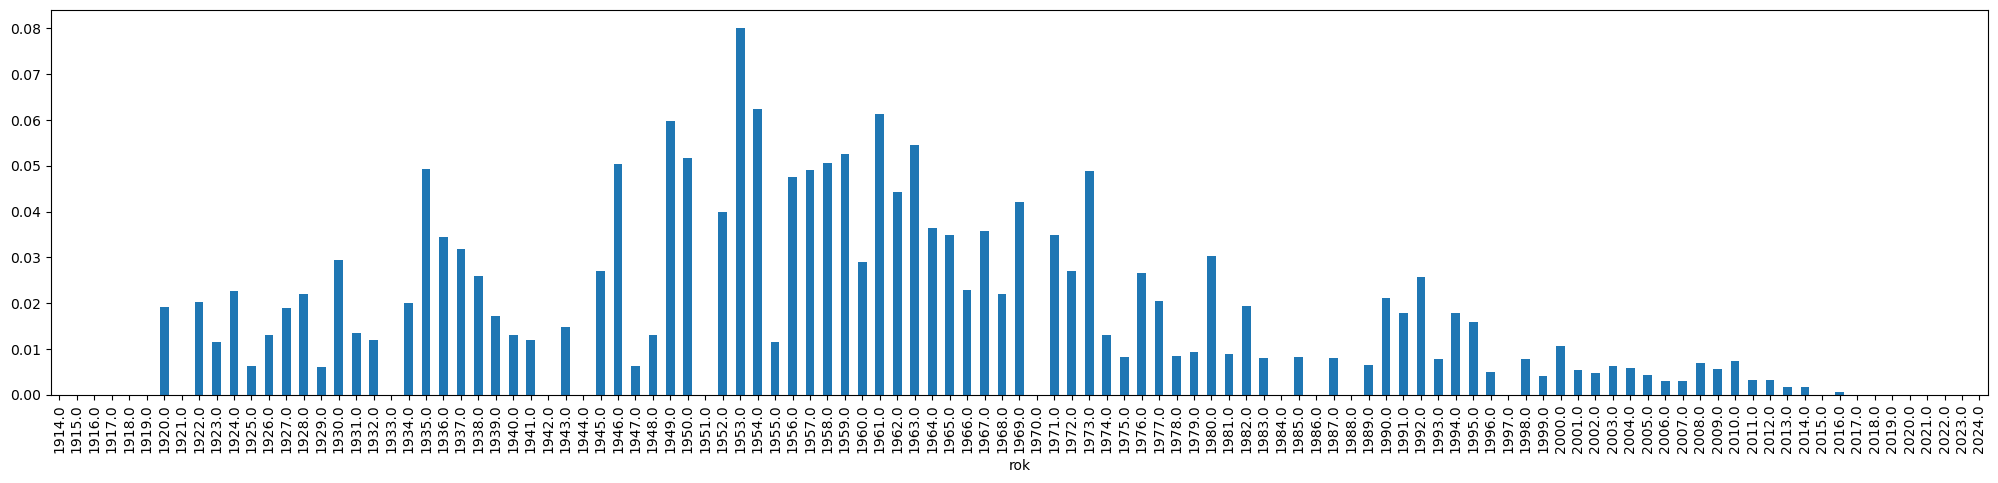

In [17]:
pd.Series(df[df['vezeni'].astype(str).str.contains('Terezín',na=False)].groupby('rok').size() / df.groupby('rok').size()).tail(111).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

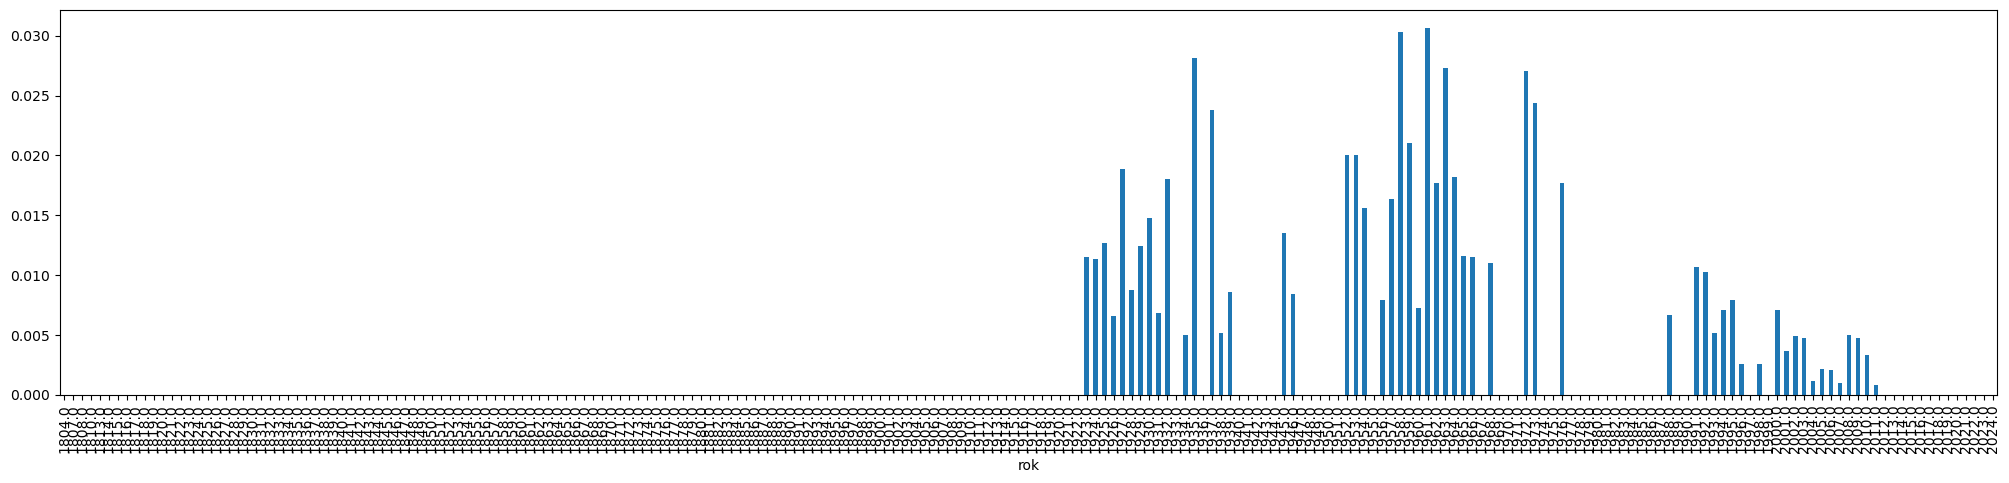

In [18]:
pd.Series(df[df['vezeni'].astype(str).str.contains('Koncentrační tábor Osvětim',na=False)].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

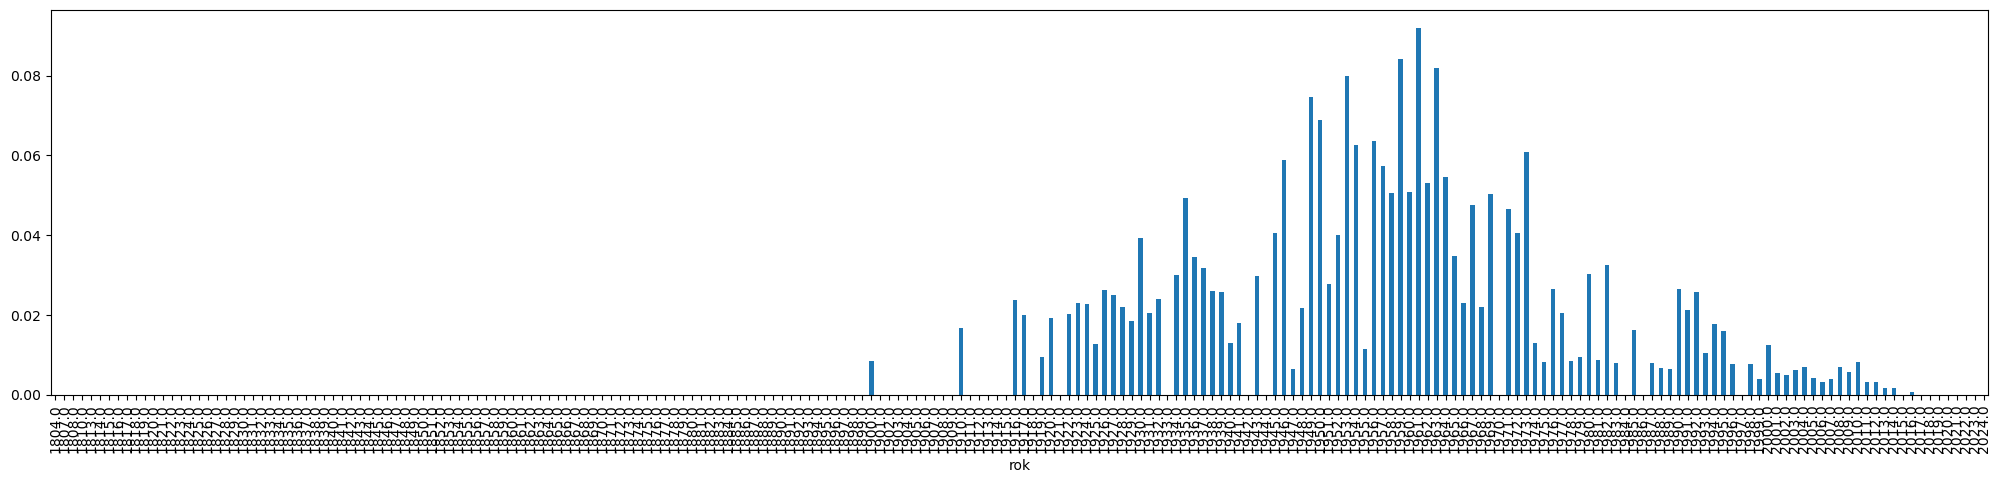

In [19]:
pd.Series(df[df['vezeni'].notnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [79]:
kriminal = (df[df['vezeni'].notnull()].groupby('rok').size() / df.groupby('rok').size())
kriminal = kriminal[kriminal.index >= 1900]

In [77]:
strana = (df[df['strany'].astype(str).str.contains('Komunistická strana Československa',na=False)].groupby('rok').size() / df.groupby('rok').size())
strana = strana[strana.index >= 1900]

In [75]:
terezin = (df[df['vezeni'].astype(str).str.contains('Terezín',na=False)].groupby('rok').size() / df.groupby('rok').size())
terezin = terezin[terezin.index >= 1900]

In [83]:
instagram = (df[df['instagram'].notnull()].groupby('rok').size() / df.groupby('rok').size())
terezin = terezin[terezin.index >= 1900]

In [85]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [87]:
def irozhlas_conf():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 14,
                      'anchor': 'start',
                       'fontWeight': 'bolder',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 12,
                       'subtitleFontWeight': 'lighter',
                      'subtitlePadding': 12,
                       'dy': -12,
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                 "fontWeight": "lighter",
                "titleFontWeight": "lighter",
                "labelFontSize": 10,
                "titleFontSize": 10,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 10,
                "titleFontSize": 10
            }
        }
    }

alt.themes.register('irozhlas', irozhlas_conf)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')

In [89]:
titulek = "Ze kterých jazyků se kdy překládaly knihy do češtiny"
podtitulek = ["Podíl jazyků na překladové literatuře – krásné, naučné i odborné."] #,"Angličtina a francouzština (téměř) zmizely jen během 2. světové války,","kdy dominovaly překlady z němčiny. Po osvobození raketově narostl podíl ruštiny."]

In [119]:
from datetime import date

In [227]:
do_grafu = pd.concat([kriminal.reset_index().rename(columns={0:'vězení'}), strana.reset_index().rename(columns={0:'členství v KSČ'}), terezin.reset_index().rename(columns={0:'internace v Terezíně'}), instagram.reset_index().rename(columns={0:'účet na Instagramu'})]).melt(id_vars="rok", value_vars=["členství v KSČ","vězení","internace v Terezíně","účet na Instagramu"])
do_grafu['rok'] = do_grafu['rok'].astype(int)
do_grafu = do_grafu[do_grafu['rok'] >= 1900]
do_grafu['value'] = do_grafu['value'].fillna(0)
do_grafu['rok'] = do_grafu['rok'].apply(lambda x: date(year=x, month=1, day=1))
do_grafu['rok'] = pd.to_datetime(do_grafu['rok'])

In [179]:
str(do_grafu.sample(10))

'            rok              variable     value\n1089 1932-01-01                vězení       NaN\n1088 1931-01-01                vězení       NaN\n1073 1916-01-01                vězení       NaN\n1337 1930-01-01  internace v Terezíně       NaN\n1600 1852-01-01  internace v Terezíně       NaN\n322  1972-01-01        členství v KSČ       NaN\n600  1909-01-01                vězení       NaN\n1819 1946-01-01    účet na Instagramu       NaN\n2069 1946-01-01    účet na Instagramu       NaN\n2352 2013-01-01    účet na Instagramu  0.008726'

In [211]:
do_grafu.sort_values(by='rok').head(40)

,rok,variable,value
0,1900-01-01,členství v KSČ,0.000000
1057,1900-01-01,vězení,0.000000
250,1900-01-01,členství v KSČ,0.000000
2239,1900-01-01,účet na Instagramu,0.000000
841,1900-01-01,vězení,0.000000
591,1900-01-01,vězení,0.008475
716,1900-01-01,vězení,0.000000
1432,1900-01-01,internace v Terezíně,0.008475
1648,1900-01-01,internace v Terezíně,0.000000
1898,1900-01-01,účet na Instagramu,0.000000


In [171]:
do_grafu.sort_values(by='value',ascending=False)

,rok,variable,value
177,1952-01-01,členství v KSČ,0.340000
179,1954-01-01,členství v KSČ,0.265625
175,1950-01-01,členství v KSČ,0.224138
186,1961-01-01,členství v KSČ,0.214286
178,1953-01-01,členství v KSČ,0.200000
...,...,...,...
2326,1987-01-01,účet na Instagramu,NaN
2327,1988-01-01,účet na Instagramu,NaN
2328,1989-01-01,účet na Instagramu,NaN
2329,1990-01-01,účet na Instagramu,NaN


In [91]:
import polars as pl

In [199]:
alt.Chart(do_grafu, title={'text': titulek}, width=300).mark_line().encode(
    alt.X("rok:T"    ),
    alt.Y('value:Q'    ))

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [275]:
podily_faceted = alt.Chart(do_grafu, title={'text': ["Co měli autoři a autorky beletrie za sebou nebo před sebou"]}, width=300).mark_bar(width=2).encode(
    alt.X("rok:T", 
          title=None,
          axis=alt.Axis(domainOpacity=0, tickColor='#DCDDD6')
    ),
    alt.Y('value:Q', 
          axis=alt.Axis(labelExpr="datum.label * 100 + ' %'", orient='right', domainOpacity=0, tickColor='#DCDDD6'), 
          title=None
    ),
    alt.Color("variable:N", 
              title=None, 
              legend=None,
              scale=alt.Scale(range=['#445B78','#5E2D3A', '#D6534B', '#9CA545','#E09DA3']),
              sort=['vězení','internace v Terezíně','členství v KSČ','účet na Instagramu']
    ),
    row=alt.Row(
        "variable:N", 
        title=None, 
        spacing=15, 
        header=alt.Header(labelAngle=0, labelAlign='left', labelAnchor='middle', labelFont='Asap'), 
        sort=['vězení','internace v Terezíně','členství v KSČ','účet na Instagramu']
    )
).resolve_scale(
    x='independent',
    y='independent'
).properties(height=100, width=300).configure_view(stroke='transparent')

podily_faceted

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [133]:
do_grafu.sample(10)

,rok,variable,value
2204,1865-01-01,účet na Instagramu,NaN
1008,1851-01-01,vězení,NaN
193,1968-01-01,členství v KSČ,0.065934
125,1900-01-01,členství v KSČ,0.008475
1145,1988-01-01,vězení,NaN
1273,1991-01-01,internace v Terezíně,NaN
1906,1908-01-01,účet na Instagramu,NaN
148,1923-01-01,členství v KSČ,NaN
2072,1949-01-01,účet na Instagramu,NaN
2288,1949-01-01,účet na Instagramu,NaN


<Axes: xlabel='rok'>

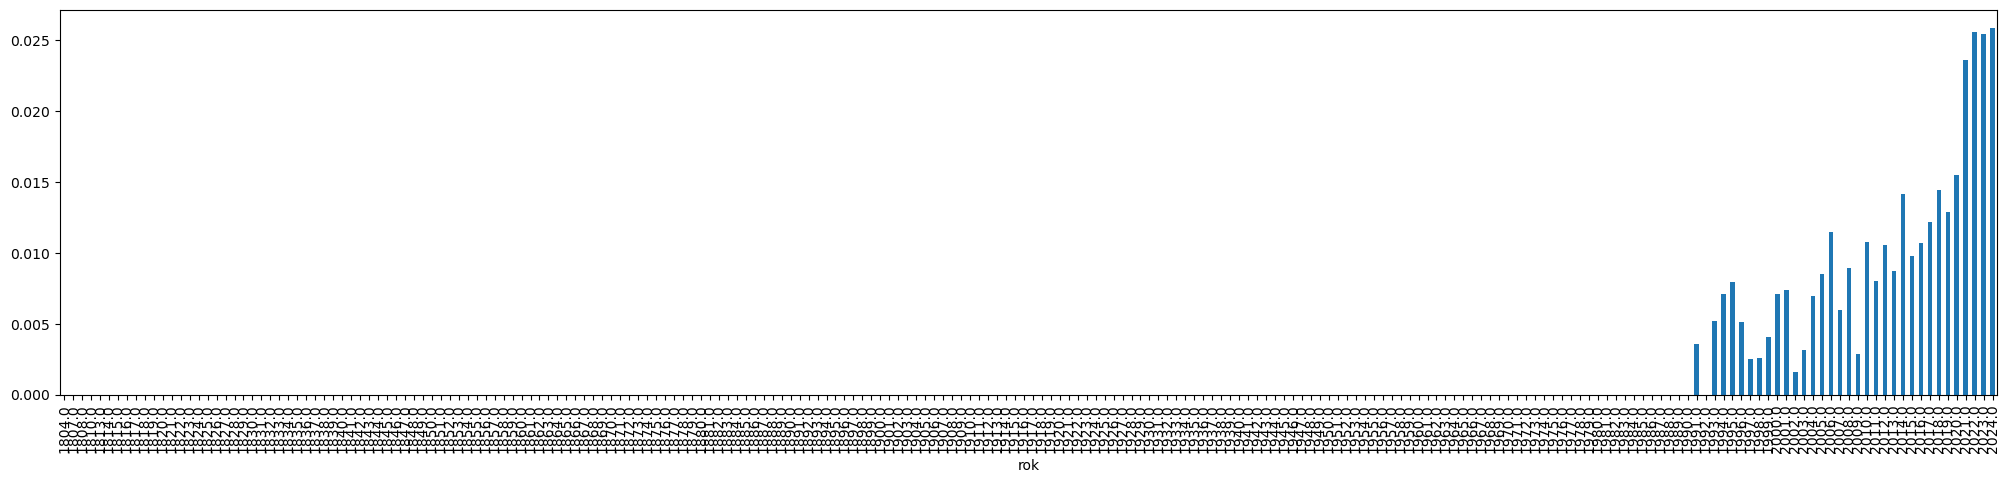

In [81]:
(df[df['instagram'].notnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

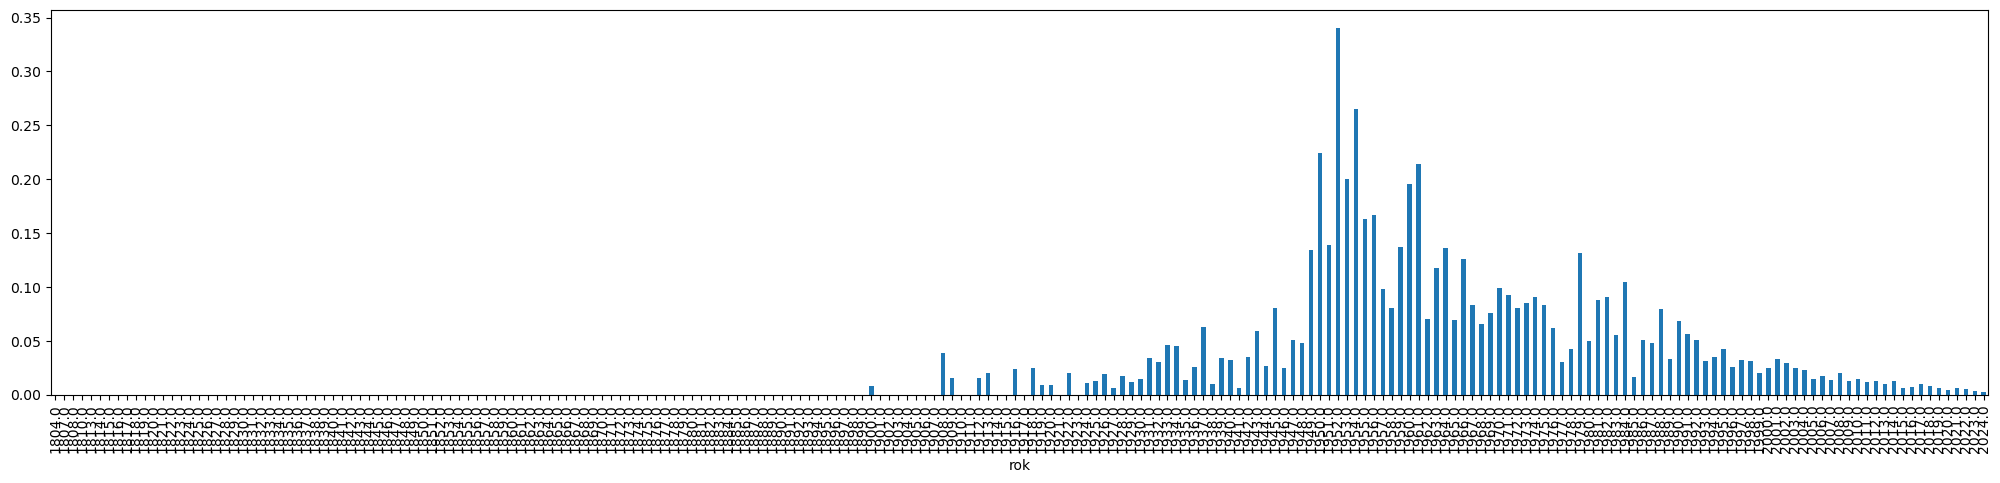

In [20]:
(df[df['strany'].astype(str).str.contains('Komunistická strana Československa',na=False)].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

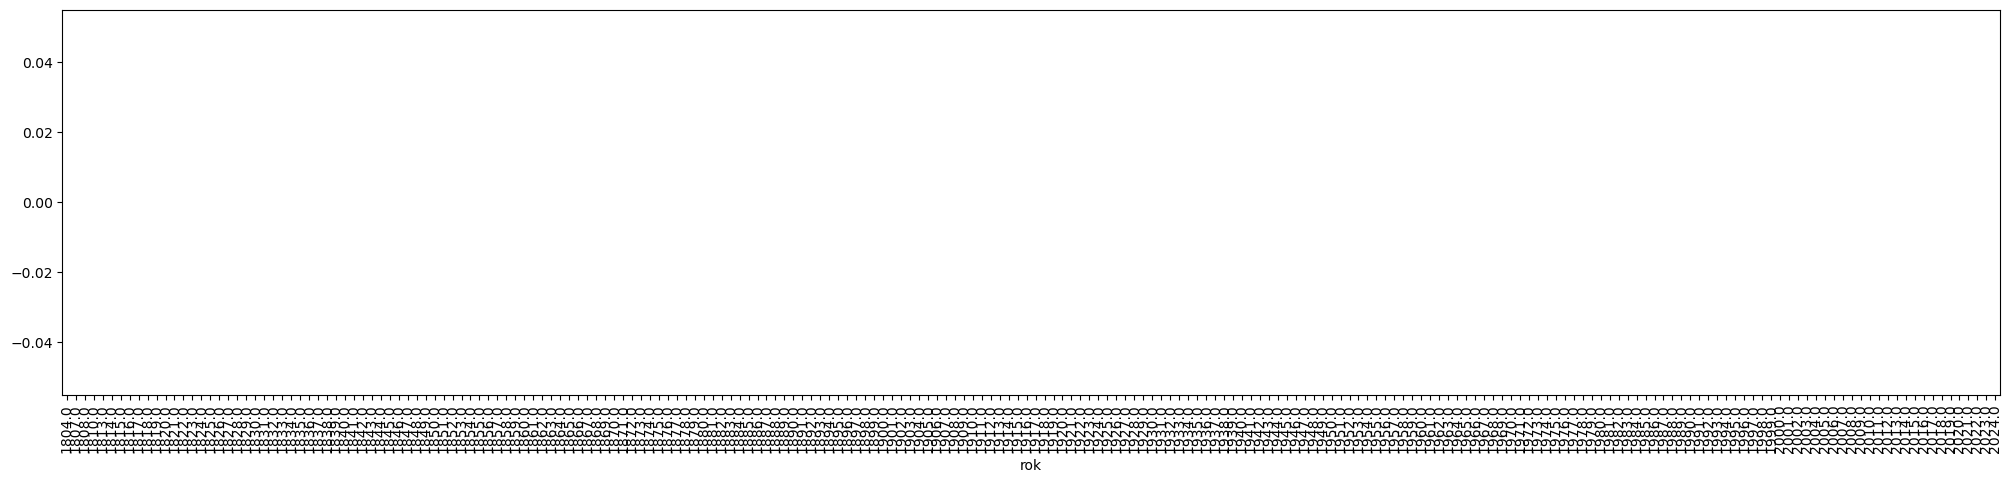

In [21]:
pd.Series(df[df['strany'].astype(str).str.contains('Q828099',na=False)].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

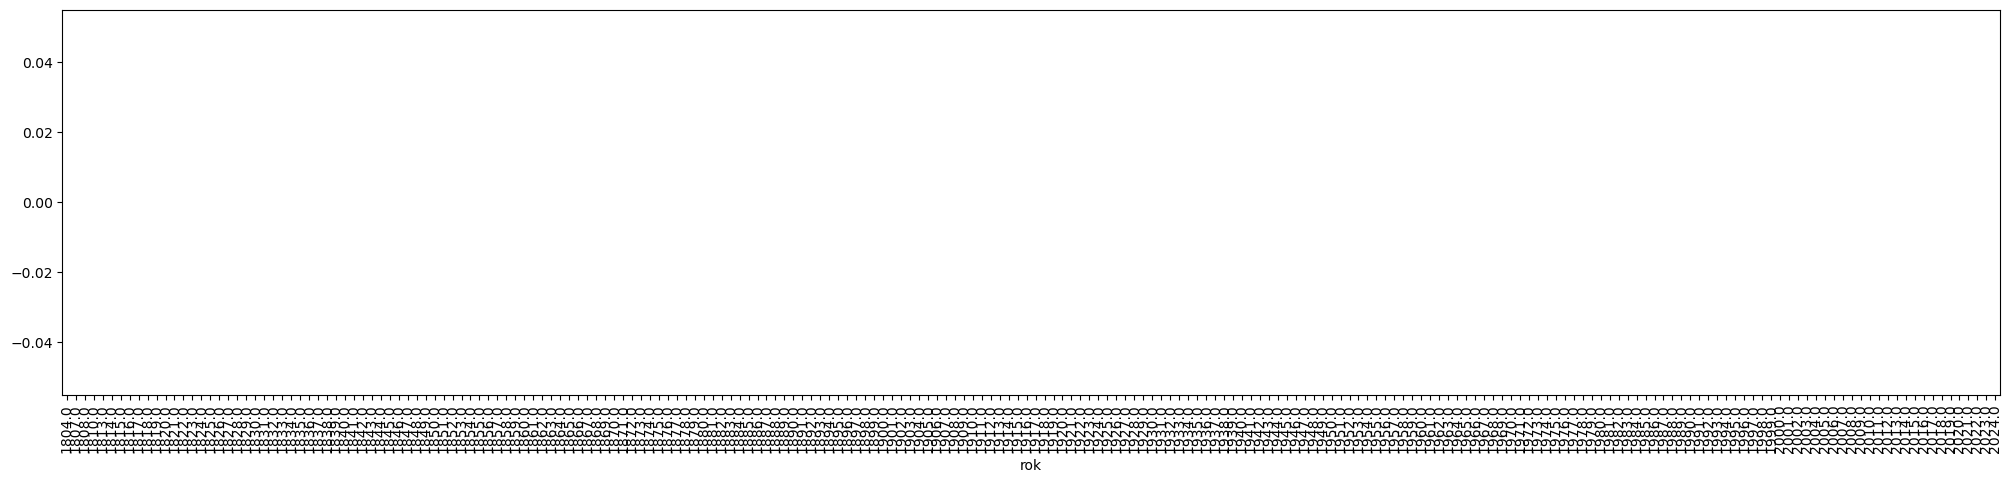

In [22]:
pd.Series(df[df['strany'].astype(str).str.contains('Q727724',na=False)].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [23]:
df.explode('udalosti').groupby('udalosti').size().nlargest(10)

udalosti
svatba          127
ordinace        105
Transport Ek     74
Transport Cc     52
odvod branců     39
Transport L      36
emigrace         32
Transport Dh     18
Transport Di     14
rozvod           14
dtype: int64

<Axes: xlabel='rok'>

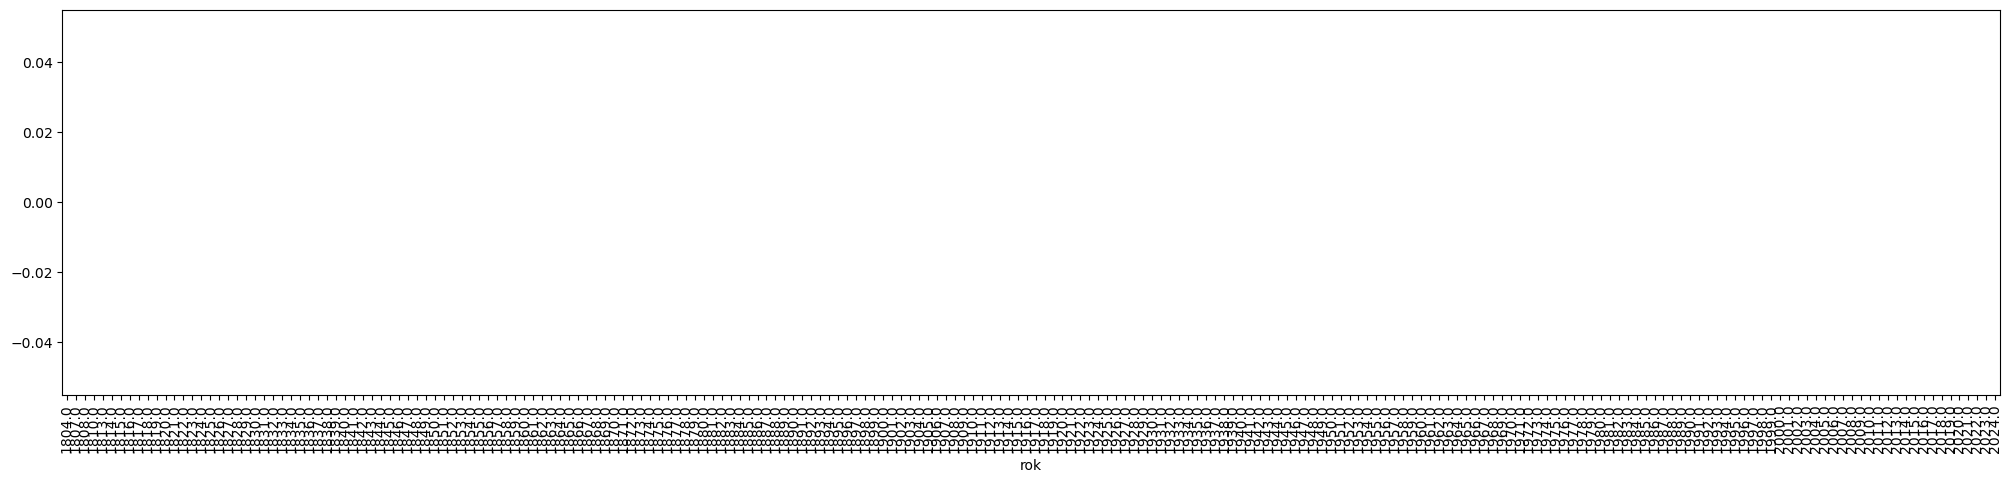

In [24]:
pd.Series(df[df['udalosti'].astype(str).str.contains('Q76358450',na=False)].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [25]:
df.explode('druh_umrti').groupby('druh_umrti').size().nlargest(10)

druh_umrti
přirozená smrt             406
sebevražda                  63
trest smrti                 14
smrtelná nehoda             12
nepřirozená smrt             3
zabití člověka člověkem      1
dtype: int64

<Axes: xlabel='rok'>

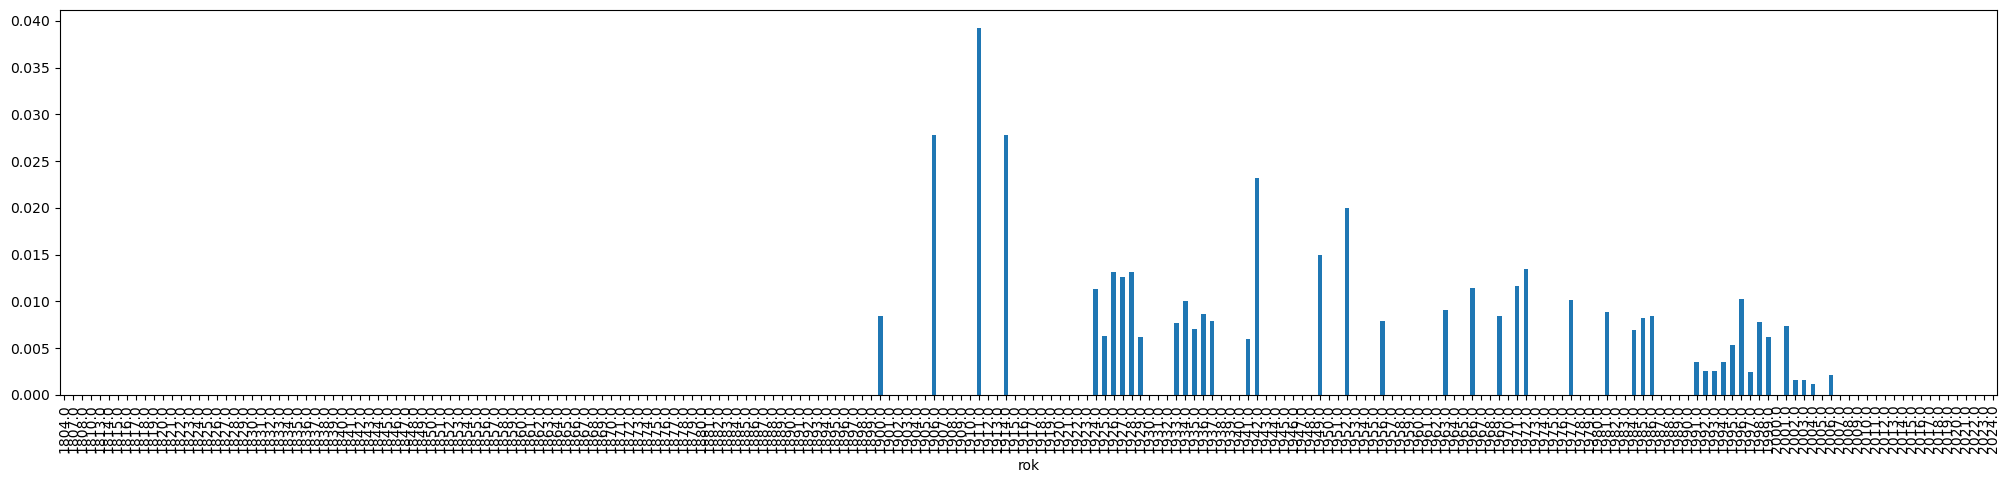

In [26]:
(df[df['druh_umrti'].astype(str).str.contains('sebevražda')].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

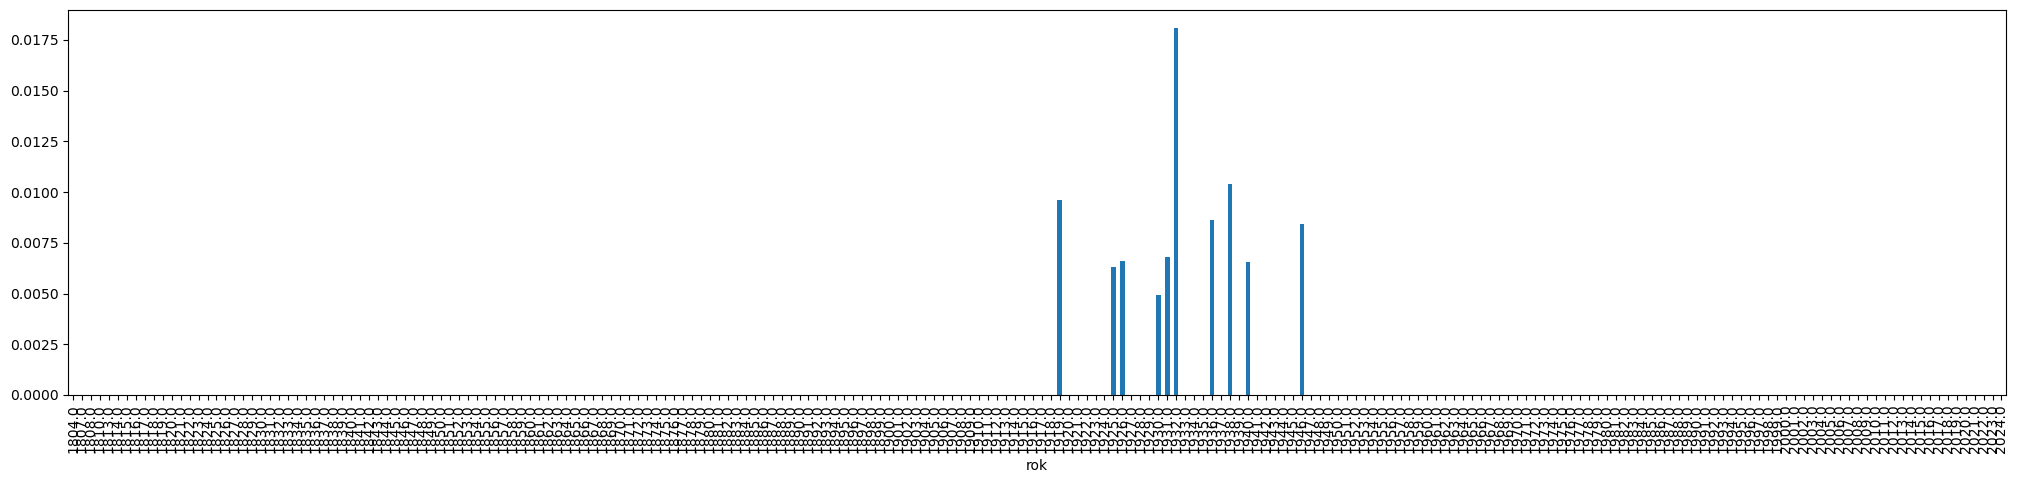

In [27]:
(df[df['druh_umrti'].astype(str).str.contains('trest smrti')].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

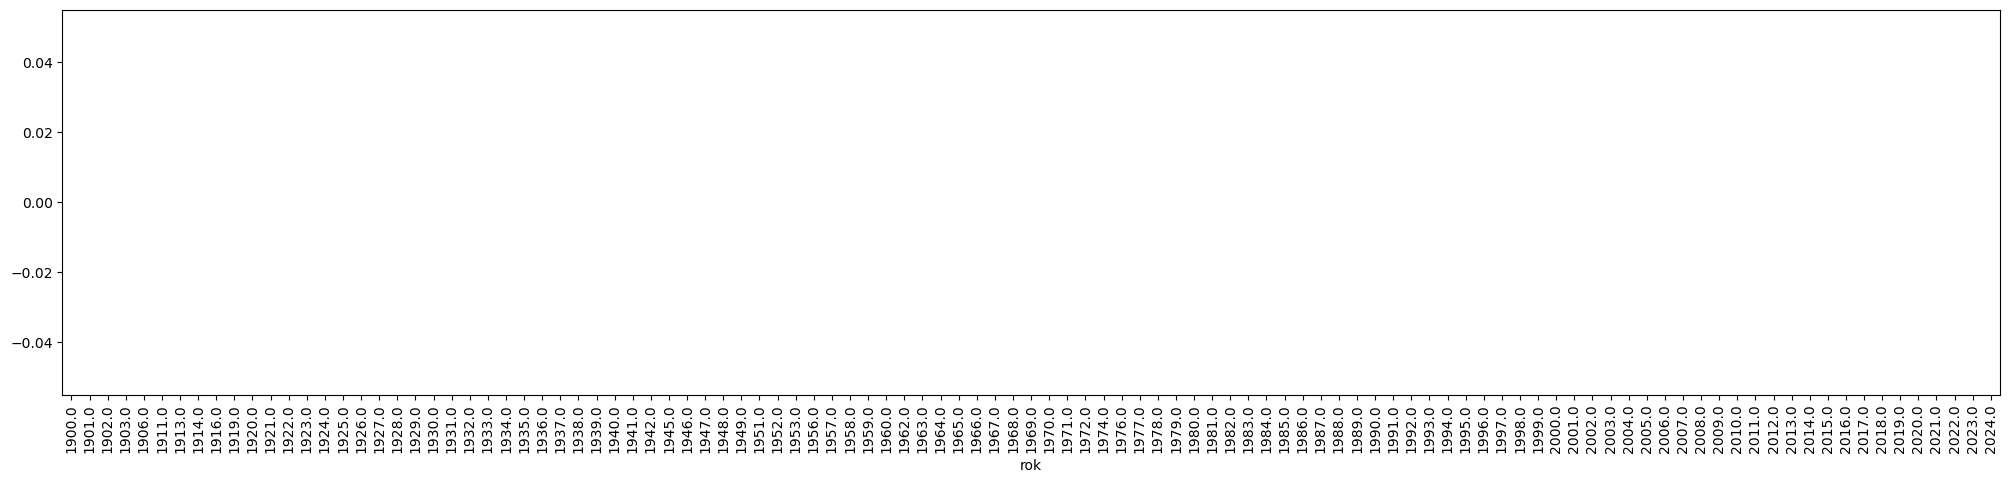

In [28]:
(df[df['druh_umrti'].astype(str).str.contains('Q10737')].groupby('rok').size() / df[df['druh_umrti'].notnull()].groupby('rok').size()).plot.bar(figsize=(25,5))